In [1]:
cd

C:\Users\Walter


In [2]:
cd Desktop/DataMiningTechniques/Assignment 1

C:\Users\Walter\Desktop\DataMiningTechniques\Assignment 1


In [3]:
cd patient_data/

C:\Users\Walter\Desktop\DataMiningTechniques\Assignment 1\patient_data


In [4]:
import pandas as pd
import pickle
from datetime import datetime
import re
from matplotlib import pyplot as plt
import numpy as np
#from sklearn import tree
#from sklearn.ensemble import RandomForestClassifier
import sklearn.ensemble as ske
#import graphviz 
#from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler, scale
import math
#from sklearn.decomposition import PCA
#from sklearn.neighbors import KNeighborsRegressor

In [5]:
data_best_F_mse = pd.read_csv('Best_F_MSE', index_col=0, usecols=range(0,11))
data_best_F_corr = pd.read_csv('Best_F_Corr.csv',  index_col=0, usecols=range(1,12))

In [6]:
# Copy from internet

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#LSTM_opt = np.zeros([6,9])

#for n_features in [2]:
#    for lag in [3]:

n_features = 7
lag = 1

mses = []

#for i in range(12):  # Walter
#for i in range(12, 23): # Arran
for i in range(23, 34): # Viktor

    
    squared_error = []
        # load patient data
    try:
        data = pd.read_csv(open('p{:02d}.csv'.format(i),'rb'), index_col=0, parse_dates=True)
    except:
        continue

    print('\n --- Patient {:02d} ---'.format(i))

    data_reindexed = data.loc[:,data_best_F_mse.loc[i].values]
    #data_reindexed = data.loc[:,data_best_F_corr.loc[i].values]

    dataset = data_reindexed.iloc[:,:n_features]
    values = dataset.values

    seg = [0.7, 0.1, 0.2]
    t = len(dataset)
    splits = [math.floor(seg[0]*t), math.floor((seg[0]+seg[1])*t)]

    #ys = values[splits[0]:,0]
    ys = values[splits[1]:,0]

    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, lag, 1)

    # split into train and test sets
    values = reframed.values

    #for tt in range(t-splits[0]-1-math.floor((seg[2]*t))):
    for tt in range(t-splits[1]-lag):

        #train = values[:splits[0]+tt, :]
        train = values[:splits[1]+tt, :]
        #test = values[splits[0]+tt:splits[0]+math.floor((seg[1]*t)), :]
        test = values[splits[1]+tt:, :]
        #val = values[splits[0]+tt,:]
        val = values[splits[1]+tt,:]

        # split into input and outputs
        n_obs = lag * n_features
        train_X, train_y = train[:, :n_obs], train[:, -n_features]
        test_X, test_y = test[:, :n_obs], test[:, -n_features]
        val_X, val_y = val[:n_obs], val[-n_features]

        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], lag, n_features))
        test_X = test_X.reshape((test_X.shape[0], lag, n_features))
        val_X = val_X.reshape((1, lag, n_features))

        # design network
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam');
        # fit network
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False);

        # make a prediction
        yhat = model.predict(val_X)
        val_X = val_X.reshape((val_X.shape[0], lag*n_features))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, val_X[:, -(n_features-1):]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[0][0]
        #inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        #inv_y = concatenate((val_y, val_X[:, -(n_features-1):]), axis=1)
        #inv_y = scaler.inverse_transform(inv_y)
        inv_y = ys[tt+lag]
        #inv_y = inv_y[:,0]
        # calculate RMSE
        print('Predicted:', inv_yhat)
        print('Real:', inv_y)
        squared_error.append((inv_y - inv_yhat)**2)

    mse = np.mean(squared_error)
    print('\nMSE: {}'.format(mse))
    #print('Number of validations:', math.floor(t*seg[1]))
    mses.append(mse)
    
print('All MSES',mses)
        #LSTM_opt[lag, n_features] = np.mean(mses)
print('\n\nAvg. MSE (all patients): {} \n lag order: {} \n nr of features: {} '.format(np.mean(mses), lag, n_features))

Using TensorFlow backend.



 --- Patient 23 ---
Train on 31 samples, validate on 7 samples
Epoch 1/50
 - 1s - loss: 0.6075 - val_loss: 0.7769
Epoch 2/50
 - 0s - loss: 0.6000 - val_loss: 0.7676
Epoch 3/50
 - 0s - loss: 0.5931 - val_loss: 0.7584
Epoch 4/50
 - 0s - loss: 0.5864 - val_loss: 0.7492
Epoch 5/50
 - 0s - loss: 0.5796 - val_loss: 0.7400
Epoch 6/50
 - 0s - loss: 0.5729 - val_loss: 0.7308
Epoch 7/50
 - 0s - loss: 0.5661 - val_loss: 0.7216
Epoch 8/50
 - 0s - loss: 0.5594 - val_loss: 0.7124
Epoch 9/50
 - 0s - loss: 0.5526 - val_loss: 0.7031
Epoch 10/50
 - 0s - loss: 0.5458 - val_loss: 0.6938
Epoch 11/50
 - 0s - loss: 0.5390 - val_loss: 0.6845
Epoch 12/50
 - 0s - loss: 0.5321 - val_loss: 0.6752
Epoch 13/50
 - 0s - loss: 0.5253 - val_loss: 0.6658
Epoch 14/50
 - 0s - loss: 0.5184 - val_loss: 0.6563
Epoch 15/50
 - 0s - loss: 0.5114 - val_loss: 0.6468
Epoch 16/50
 - 0s - loss: 0.5045 - val_loss: 0.6372
Epoch 17/50
 - 0s - loss: 0.4975 - val_loss: 0.6276
Epoch 18/50
 - 0s - loss: 0.4904 - val_loss: 0.6179
Epoch 19/

Epoch 3/50
 - 0s - loss: 0.6574 - val_loss: 0.7952
Epoch 4/50
 - 0s - loss: 0.6493 - val_loss: 0.7854
Epoch 5/50
 - 0s - loss: 0.6412 - val_loss: 0.7757
Epoch 6/50
 - 0s - loss: 0.6331 - val_loss: 0.7660
Epoch 7/50
 - 0s - loss: 0.6257 - val_loss: 0.7563
Epoch 8/50
 - 0s - loss: 0.6190 - val_loss: 0.7467
Epoch 9/50
 - 0s - loss: 0.6122 - val_loss: 0.7372
Epoch 10/50
 - 0s - loss: 0.6055 - val_loss: 0.7277
Epoch 11/50
 - 0s - loss: 0.5988 - val_loss: 0.7181
Epoch 12/50
 - 0s - loss: 0.5921 - val_loss: 0.7086
Epoch 13/50
 - 0s - loss: 0.5854 - val_loss: 0.6991
Epoch 14/50
 - 0s - loss: 0.5787 - val_loss: 0.6896
Epoch 15/50
 - 0s - loss: 0.5719 - val_loss: 0.6801
Epoch 16/50
 - 0s - loss: 0.5652 - val_loss: 0.6706
Epoch 17/50
 - 0s - loss: 0.5584 - val_loss: 0.6610
Epoch 18/50
 - 0s - loss: 0.5516 - val_loss: 0.6514
Epoch 19/50
 - 0s - loss: 0.5448 - val_loss: 0.6417
Epoch 20/50
 - 0s - loss: 0.5380 - val_loss: 0.6320
Epoch 21/50
 - 0s - loss: 0.5311 - val_loss: 0.6223
Epoch 22/50
 - 0s -

Epoch 7/50
 - 0s - loss: 0.6205 - val_loss: 0.6809
Epoch 8/50
 - 0s - loss: 0.6138 - val_loss: 0.6697
Epoch 9/50
 - 0s - loss: 0.6071 - val_loss: 0.6585
Epoch 10/50
 - 0s - loss: 0.6003 - val_loss: 0.6473
Epoch 11/50
 - 0s - loss: 0.5934 - val_loss: 0.6360
Epoch 12/50
 - 0s - loss: 0.5866 - val_loss: 0.6247
Epoch 13/50
 - 0s - loss: 0.5798 - val_loss: 0.6133
Epoch 14/50
 - 0s - loss: 0.5729 - val_loss: 0.6019
Epoch 15/50
 - 0s - loss: 0.5660 - val_loss: 0.5903
Epoch 16/50
 - 0s - loss: 0.5591 - val_loss: 0.5787
Epoch 17/50
 - 0s - loss: 0.5521 - val_loss: 0.5671
Epoch 18/50
 - 0s - loss: 0.5451 - val_loss: 0.5553
Epoch 19/50
 - 0s - loss: 0.5381 - val_loss: 0.5434
Epoch 20/50
 - 0s - loss: 0.5311 - val_loss: 0.5313
Epoch 21/50
 - 0s - loss: 0.5239 - val_loss: 0.5192
Epoch 22/50
 - 0s - loss: 0.5168 - val_loss: 0.5070
Epoch 23/50
 - 0s - loss: 0.5096 - val_loss: 0.4946
Epoch 24/50
 - 0s - loss: 0.5023 - val_loss: 0.4821
Epoch 25/50
 - 0s - loss: 0.4950 - val_loss: 0.4695
Epoch 26/50
 - 

Epoch 10/50
 - 0s - loss: 0.5628 - val_loss: 0.6609
Epoch 11/50
 - 0s - loss: 0.5543 - val_loss: 0.6523
Epoch 12/50
 - 0s - loss: 0.5459 - val_loss: 0.6436
Epoch 13/50
 - 0s - loss: 0.5375 - val_loss: 0.6348
Epoch 14/50
 - 0s - loss: 0.5290 - val_loss: 0.6261
Epoch 15/50
 - 0s - loss: 0.5205 - val_loss: 0.6173
Epoch 16/50
 - 0s - loss: 0.5119 - val_loss: 0.6085
Epoch 17/50
 - 0s - loss: 0.5033 - val_loss: 0.5996
Epoch 18/50
 - 0s - loss: 0.4947 - val_loss: 0.5908
Epoch 19/50
 - 0s - loss: 0.4861 - val_loss: 0.5818
Epoch 20/50
 - 0s - loss: 0.4774 - val_loss: 0.5729
Epoch 21/50
 - 0s - loss: 0.4687 - val_loss: 0.5638
Epoch 22/50
 - 0s - loss: 0.4599 - val_loss: 0.5547
Epoch 23/50
 - 0s - loss: 0.4510 - val_loss: 0.5456
Epoch 24/50
 - 0s - loss: 0.4421 - val_loss: 0.5363
Epoch 25/50
 - 0s - loss: 0.4330 - val_loss: 0.5270
Epoch 26/50
 - 0s - loss: 0.4240 - val_loss: 0.5176
Epoch 27/50
 - 0s - loss: 0.4149 - val_loss: 0.5082
Epoch 28/50
 - 0s - loss: 0.4057 - val_loss: 0.4986
Epoch 29/50


Epoch 14/50
 - 0s - loss: 0.5348 - val_loss: 0.6588
Epoch 15/50
 - 0s - loss: 0.5281 - val_loss: 0.6516
Epoch 16/50
 - 0s - loss: 0.5214 - val_loss: 0.6443
Epoch 17/50
 - 0s - loss: 0.5147 - val_loss: 0.6370
Epoch 18/50
 - 0s - loss: 0.5079 - val_loss: 0.6296
Epoch 19/50
 - 0s - loss: 0.5010 - val_loss: 0.6221
Epoch 20/50
 - 0s - loss: 0.4940 - val_loss: 0.6146
Epoch 21/50
 - 0s - loss: 0.4870 - val_loss: 0.6069
Epoch 22/50
 - 0s - loss: 0.4799 - val_loss: 0.5992
Epoch 23/50
 - 0s - loss: 0.4728 - val_loss: 0.5914
Epoch 24/50
 - 0s - loss: 0.4655 - val_loss: 0.5835
Epoch 25/50
 - 0s - loss: 0.4582 - val_loss: 0.5755
Epoch 26/50
 - 0s - loss: 0.4508 - val_loss: 0.5674
Epoch 27/50
 - 0s - loss: 0.4433 - val_loss: 0.5593
Epoch 28/50
 - 0s - loss: 0.4357 - val_loss: 0.5509
Epoch 29/50
 - 0s - loss: 0.4279 - val_loss: 0.5425
Epoch 30/50
 - 0s - loss: 0.4201 - val_loss: 0.5340
Epoch 31/50
 - 0s - loss: 0.4122 - val_loss: 0.5253
Epoch 32/50
 - 0s - loss: 0.4042 - val_loss: 0.5166
Epoch 33/50


Epoch 18/50
 - 0s - loss: 0.4667 - val_loss: 0.6345
Epoch 19/50
 - 0s - loss: 0.4587 - val_loss: 0.6263
Epoch 20/50
 - 0s - loss: 0.4506 - val_loss: 0.6179
Epoch 21/50
 - 0s - loss: 0.4423 - val_loss: 0.6095
Epoch 22/50
 - 0s - loss: 0.4339 - val_loss: 0.6009
Epoch 23/50
 - 0s - loss: 0.4254 - val_loss: 0.5924
Epoch 24/50
 - 0s - loss: 0.4169 - val_loss: 0.5838
Epoch 25/50
 - 0s - loss: 0.4085 - val_loss: 0.5751
Epoch 26/50
 - 0s - loss: 0.4002 - val_loss: 0.5663
Epoch 27/50
 - 0s - loss: 0.3919 - val_loss: 0.5574
Epoch 28/50
 - 0s - loss: 0.3835 - val_loss: 0.5484
Epoch 29/50
 - 0s - loss: 0.3750 - val_loss: 0.5394
Epoch 30/50
 - 0s - loss: 0.3664 - val_loss: 0.5302
Epoch 31/50
 - 0s - loss: 0.3578 - val_loss: 0.5210
Epoch 32/50
 - 0s - loss: 0.3494 - val_loss: 0.5116
Epoch 33/50
 - 0s - loss: 0.3408 - val_loss: 0.5021
Epoch 34/50
 - 0s - loss: 0.3323 - val_loss: 0.4925
Epoch 35/50
 - 0s - loss: 0.3235 - val_loss: 0.4829
Epoch 36/50
 - 0s - loss: 0.3147 - val_loss: 0.4731
Epoch 37/50


Epoch 21/50
 - 0s - loss: 0.2500 - val_loss: 0.1171
Epoch 22/50
 - 0s - loss: 0.2472 - val_loss: 0.1144
Epoch 23/50
 - 0s - loss: 0.2450 - val_loss: 0.1150
Epoch 24/50
 - 0s - loss: 0.2431 - val_loss: 0.1157
Epoch 25/50
 - 0s - loss: 0.2412 - val_loss: 0.1164
Epoch 26/50
 - 0s - loss: 0.2394 - val_loss: 0.1171
Epoch 27/50
 - 0s - loss: 0.2382 - val_loss: 0.1177
Epoch 28/50
 - 0s - loss: 0.2374 - val_loss: 0.1182
Epoch 29/50
 - 0s - loss: 0.2367 - val_loss: 0.1188
Epoch 30/50
 - 0s - loss: 0.2359 - val_loss: 0.1193
Epoch 31/50
 - 0s - loss: 0.2352 - val_loss: 0.1197
Epoch 32/50
 - 0s - loss: 0.2344 - val_loss: 0.1201
Epoch 33/50
 - 0s - loss: 0.2337 - val_loss: 0.1205
Epoch 34/50
 - 0s - loss: 0.2329 - val_loss: 0.1209
Epoch 35/50
 - 0s - loss: 0.2322 - val_loss: 0.1213
Epoch 36/50
 - 0s - loss: 0.2314 - val_loss: 0.1216
Epoch 37/50
 - 0s - loss: 0.2307 - val_loss: 0.1219
Epoch 38/50
 - 0s - loss: 0.2299 - val_loss: 0.1222
Epoch 39/50
 - 0s - loss: 0.2292 - val_loss: 0.1225
Epoch 40/50


Epoch 25/50
 - 0s - loss: 0.2376 - val_loss: 0.1384
Epoch 26/50
 - 0s - loss: 0.2328 - val_loss: 0.1371
Epoch 27/50
 - 0s - loss: 0.2291 - val_loss: 0.1359
Epoch 28/50
 - 0s - loss: 0.2259 - val_loss: 0.1347
Epoch 29/50
 - 0s - loss: 0.2234 - val_loss: 0.1336
Epoch 30/50
 - 0s - loss: 0.2219 - val_loss: 0.1326
Epoch 31/50
 - 0s - loss: 0.2211 - val_loss: 0.1317
Epoch 32/50
 - 0s - loss: 0.2203 - val_loss: 0.1310
Epoch 33/50
 - 0s - loss: 0.2196 - val_loss: 0.1303
Epoch 34/50
 - 0s - loss: 0.2192 - val_loss: 0.1297
Epoch 35/50
 - 0s - loss: 0.2188 - val_loss: 0.1292
Epoch 36/50
 - 0s - loss: 0.2184 - val_loss: 0.1289
Epoch 37/50
 - 0s - loss: 0.2179 - val_loss: 0.1286
Epoch 38/50
 - 0s - loss: 0.2175 - val_loss: 0.1283
Epoch 39/50
 - 0s - loss: 0.2170 - val_loss: 0.1282
Epoch 40/50
 - 0s - loss: 0.2165 - val_loss: 0.1281
Epoch 41/50
 - 0s - loss: 0.2160 - val_loss: 0.1281
Epoch 42/50
 - 0s - loss: 0.2154 - val_loss: 0.1281
Epoch 43/50
 - 0s - loss: 0.2149 - val_loss: 0.1282
Epoch 44/50


Epoch 28/50
 - 0s - loss: 0.3272 - val_loss: 0.3510
Epoch 29/50
 - 0s - loss: 0.3180 - val_loss: 0.3413
Epoch 30/50
 - 0s - loss: 0.3093 - val_loss: 0.3317
Epoch 31/50
 - 0s - loss: 0.3008 - val_loss: 0.3221
Epoch 32/50
 - 0s - loss: 0.2923 - val_loss: 0.3124
Epoch 33/50
 - 0s - loss: 0.2844 - val_loss: 0.3028
Epoch 34/50
 - 0s - loss: 0.2772 - val_loss: 0.2932
Epoch 35/50
 - 0s - loss: 0.2704 - val_loss: 0.2836
Epoch 36/50
 - 0s - loss: 0.2636 - val_loss: 0.2743
Epoch 37/50
 - 0s - loss: 0.2568 - val_loss: 0.2663
Epoch 38/50
 - 0s - loss: 0.2500 - val_loss: 0.2583
Epoch 39/50
 - 0s - loss: 0.2439 - val_loss: 0.2504
Epoch 40/50
 - 0s - loss: 0.2385 - val_loss: 0.2440
Epoch 41/50
 - 0s - loss: 0.2331 - val_loss: 0.2382
Epoch 42/50
 - 0s - loss: 0.2278 - val_loss: 0.2323
Epoch 43/50
 - 0s - loss: 0.2225 - val_loss: 0.2265
Epoch 44/50
 - 0s - loss: 0.2172 - val_loss: 0.2206
Epoch 45/50
 - 0s - loss: 0.2118 - val_loss: 0.2148
Epoch 46/50
 - 0s - loss: 0.2065 - val_loss: 0.2089
Epoch 47/50


Epoch 31/50
 - 0s - loss: 0.2671 - val_loss: 0.2526
Epoch 32/50
 - 0s - loss: 0.2603 - val_loss: 0.2470
Epoch 33/50
 - 0s - loss: 0.2535 - val_loss: 0.2436
Epoch 34/50
 - 0s - loss: 0.2471 - val_loss: 0.2402
Epoch 35/50
 - 0s - loss: 0.2406 - val_loss: 0.2368
Epoch 36/50
 - 0s - loss: 0.2343 - val_loss: 0.2333
Epoch 37/50
 - 0s - loss: 0.2282 - val_loss: 0.2299
Epoch 38/50
 - 0s - loss: 0.2222 - val_loss: 0.2264
Epoch 39/50
 - 0s - loss: 0.2164 - val_loss: 0.2229
Epoch 40/50
 - 0s - loss: 0.2105 - val_loss: 0.2198
Epoch 41/50
 - 0s - loss: 0.2046 - val_loss: 0.2191
Epoch 42/50
 - 0s - loss: 0.1988 - val_loss: 0.2184
Epoch 43/50
 - 0s - loss: 0.1928 - val_loss: 0.2177
Epoch 44/50
 - 0s - loss: 0.1868 - val_loss: 0.2170
Epoch 45/50
 - 0s - loss: 0.1813 - val_loss: 0.2163
Epoch 46/50
 - 0s - loss: 0.1772 - val_loss: 0.2185
Epoch 47/50
 - 0s - loss: 0.1739 - val_loss: 0.2206
Epoch 48/50
 - 0s - loss: 0.1712 - val_loss: 0.2226
Epoch 49/50
 - 0s - loss: 0.1693 - val_loss: 0.2245
Epoch 50/50


Epoch 35/50
 - 0s - loss: 0.2617 - val_loss: 0.2969
Epoch 36/50
 - 0s - loss: 0.2547 - val_loss: 0.2937
Epoch 37/50
 - 0s - loss: 0.2479 - val_loss: 0.2906
Epoch 38/50
 - 0s - loss: 0.2412 - val_loss: 0.2874
Epoch 39/50
 - 0s - loss: 0.2347 - val_loss: 0.2843
Epoch 40/50
 - 0s - loss: 0.2284 - val_loss: 0.2811
Epoch 41/50
 - 0s - loss: 0.2222 - val_loss: 0.2779
Epoch 42/50
 - 0s - loss: 0.2163 - val_loss: 0.2747
Epoch 43/50
 - 0s - loss: 0.2107 - val_loss: 0.2715
Epoch 44/50
 - 0s - loss: 0.2050 - val_loss: 0.2683
Epoch 45/50
 - 0s - loss: 0.1994 - val_loss: 0.2650
Epoch 46/50
 - 0s - loss: 0.1942 - val_loss: 0.2618
Epoch 47/50
 - 0s - loss: 0.1894 - val_loss: 0.2586
Epoch 48/50
 - 0s - loss: 0.1850 - val_loss: 0.2554
Epoch 49/50
 - 0s - loss: 0.1812 - val_loss: 0.2523
Epoch 50/50
 - 0s - loss: 0.1779 - val_loss: 0.2493
Predicted: 6.7802734
Real: 6.19999999999999
Train on 61 samples, validate on 6 samples
Epoch 1/50
 - 3s - loss: 0.5645 - val_loss: 0.5591
Epoch 2/50
 - 0s - loss: 0.554

 - 0s - loss: 0.2998 - val_loss: 0.2553
Epoch 39/50
 - 0s - loss: 0.2911 - val_loss: 0.2540
Epoch 40/50
 - 0s - loss: 0.2826 - val_loss: 0.2526
Epoch 41/50
 - 0s - loss: 0.2750 - val_loss: 0.2512
Epoch 42/50
 - 0s - loss: 0.2678 - val_loss: 0.2498
Epoch 43/50
 - 0s - loss: 0.2608 - val_loss: 0.2484
Epoch 44/50
 - 0s - loss: 0.2539 - val_loss: 0.2470
Epoch 45/50
 - 0s - loss: 0.2473 - val_loss: 0.2455
Epoch 46/50
 - 0s - loss: 0.2407 - val_loss: 0.2440
Epoch 47/50
 - 0s - loss: 0.2342 - val_loss: 0.2425
Epoch 48/50
 - 0s - loss: 0.2275 - val_loss: 0.2409
Epoch 49/50
 - 0s - loss: 0.2214 - val_loss: 0.2394
Epoch 50/50
 - 0s - loss: 0.2157 - val_loss: 0.2378
Predicted: 6.8493347
Real: 7.199999999999991
Train on 64 samples, validate on 3 samples
Epoch 1/50
 - 3s - loss: 0.5421 - val_loss: 0.2860
Epoch 2/50
 - 0s - loss: 0.5335 - val_loss: 0.2817
Epoch 3/50
 - 0s - loss: 0.5249 - val_loss: 0.2774
Epoch 4/50
 - 0s - loss: 0.5162 - val_loss: 0.2730
Epoch 5/50
 - 0s - loss: 0.5075 - val_loss: 

Epoch 42/50
 - 0s - loss: 0.1864 - val_loss: 0.1796
Epoch 43/50
 - 0s - loss: 0.1834 - val_loss: 0.1682
Epoch 44/50
 - 0s - loss: 0.1813 - val_loss: 0.1573
Epoch 45/50
 - 0s - loss: 0.1799 - val_loss: 0.1472
Epoch 46/50
 - 0s - loss: 0.1790 - val_loss: 0.1377
Epoch 47/50
 - 0s - loss: 0.1787 - val_loss: 0.1289
Epoch 48/50
 - 0s - loss: 0.1786 - val_loss: 0.1209
Epoch 49/50
 - 0s - loss: 0.1788 - val_loss: 0.1137
Epoch 50/50
 - 0s - loss: 0.1789 - val_loss: 0.1074
Predicted: 7.0993514
Real: 7.3999999999999915

MSE: 0.43366094321407633

 --- Patient 27 ---
Train on 33 samples, validate on 8 samples
Epoch 1/50
 - 4s - loss: 0.5097 - val_loss: 0.4365
Epoch 2/50
 - 0s - loss: 0.5010 - val_loss: 0.4279
Epoch 3/50
 - 0s - loss: 0.4924 - val_loss: 0.4194
Epoch 4/50
 - 0s - loss: 0.4838 - val_loss: 0.4109
Epoch 5/50
 - 0s - loss: 0.4752 - val_loss: 0.4024
Epoch 6/50
 - 0s - loss: 0.4671 - val_loss: 0.3940
Epoch 7/50
 - 0s - loss: 0.4590 - val_loss: 0.3856
Epoch 8/50
 - 0s - loss: 0.4510 - val_l

Epoch 45/50
 - 0s - loss: 0.1390 - val_loss: 0.1428
Epoch 46/50
 - 0s - loss: 0.1371 - val_loss: 0.1452
Epoch 47/50
 - 0s - loss: 0.1354 - val_loss: 0.1474
Epoch 48/50
 - 0s - loss: 0.1344 - val_loss: 0.1495
Epoch 49/50
 - 0s - loss: 0.1341 - val_loss: 0.1514
Epoch 50/50
 - 0s - loss: 0.1340 - val_loss: 0.1531
Predicted: 7.5673356
Real: 6.399999999999999
Train on 36 samples, validate on 5 samples
Epoch 1/50
 - 4s - loss: 0.4535 - val_loss: 0.3629
Epoch 2/50
 - 0s - loss: 0.4449 - val_loss: 0.3539
Epoch 3/50
 - 0s - loss: 0.4363 - val_loss: 0.3449
Epoch 4/50
 - 0s - loss: 0.4277 - val_loss: 0.3364
Epoch 5/50
 - 0s - loss: 0.4195 - val_loss: 0.3273
Epoch 6/50
 - 0s - loss: 0.4108 - val_loss: 0.3182
Epoch 7/50
 - 0s - loss: 0.4021 - val_loss: 0.3090
Epoch 8/50
 - 0s - loss: 0.3933 - val_loss: 0.2999
Epoch 9/50
 - 0s - loss: 0.3845 - val_loss: 0.2906
Epoch 10/50
 - 0s - loss: 0.3757 - val_loss: 0.2813
Epoch 11/50
 - 0s - loss: 0.3668 - val_loss: 0.2720
Epoch 12/50
 - 0s - loss: 0.3579 - va

Epoch 48/50
 - 0s - loss: 0.1304 - val_loss: 0.0853
Epoch 49/50
 - 0s - loss: 0.1302 - val_loss: 0.0864
Epoch 50/50
 - 0s - loss: 0.1302 - val_loss: 0.0873
Predicted: 8.010585
Real: 7.799999999999998
Train on 39 samples, validate on 2 samples
Epoch 1/50
 - 4s - loss: 0.4680 - val_loss: 0.3968
Epoch 2/50
 - 0s - loss: 0.4582 - val_loss: 0.3880
Epoch 3/50
 - 0s - loss: 0.4488 - val_loss: 0.3792
Epoch 4/50
 - 0s - loss: 0.4394 - val_loss: 0.3705
Epoch 5/50
 - 0s - loss: 0.4300 - val_loss: 0.3617
Epoch 6/50
 - 0s - loss: 0.4206 - val_loss: 0.3532
Epoch 7/50
 - 0s - loss: 0.4114 - val_loss: 0.3444
Epoch 8/50
 - 0s - loss: 0.4020 - val_loss: 0.3357
Epoch 9/50
 - 0s - loss: 0.3926 - val_loss: 0.3270
Epoch 10/50
 - 0s - loss: 0.3832 - val_loss: 0.3182
Epoch 11/50
 - 0s - loss: 0.3737 - val_loss: 0.3094
Epoch 12/50
 - 0s - loss: 0.3642 - val_loss: 0.3006
Epoch 13/50
 - 0s - loss: 0.3547 - val_loss: 0.2917
Epoch 14/50
 - 0s - loss: 0.3452 - val_loss: 0.2828
Epoch 15/50
 - 0s - loss: 0.3356 - val

 - 0s - loss: 0.2760 - val_loss: 0.0839
Predicted: 6.320143
Real: 6.4
Train on 31 samples, validate on 6 samples
Epoch 1/50
 - 4s - loss: 0.6255 - val_loss: 0.4533
Epoch 2/50
 - 0s - loss: 0.6179 - val_loss: 0.4449
Epoch 3/50
 - 0s - loss: 0.6103 - val_loss: 0.4365
Epoch 4/50
 - 0s - loss: 0.6027 - val_loss: 0.4281
Epoch 5/50
 - 0s - loss: 0.5951 - val_loss: 0.4197
Epoch 6/50
 - 0s - loss: 0.5874 - val_loss: 0.4112
Epoch 7/50
 - 0s - loss: 0.5798 - val_loss: 0.4027
Epoch 8/50
 - 0s - loss: 0.5721 - val_loss: 0.3942
Epoch 9/50
 - 0s - loss: 0.5643 - val_loss: 0.3856
Epoch 10/50
 - 0s - loss: 0.5566 - val_loss: 0.3770
Epoch 11/50
 - 0s - loss: 0.5488 - val_loss: 0.3684
Epoch 12/50
 - 0s - loss: 0.5409 - val_loss: 0.3597
Epoch 13/50
 - 0s - loss: 0.5330 - val_loss: 0.3510
Epoch 14/50
 - 0s - loss: 0.5251 - val_loss: 0.3421
Epoch 15/50
 - 0s - loss: 0.5171 - val_loss: 0.3333
Epoch 16/50
 - 0s - loss: 0.5095 - val_loss: 0.3244
Epoch 17/50
 - 0s - loss: 0.5021 - val_loss: 0.3155
Epoch 18/50


Epoch 2/50
 - 0s - loss: 0.6042 - val_loss: 0.3684
Epoch 3/50
 - 0s - loss: 0.5956 - val_loss: 0.3602
Epoch 4/50
 - 0s - loss: 0.5878 - val_loss: 0.3520
Epoch 5/50
 - 0s - loss: 0.5799 - val_loss: 0.3441
Epoch 6/50
 - 0s - loss: 0.5724 - val_loss: 0.3359
Epoch 7/50
 - 0s - loss: 0.5646 - val_loss: 0.3277
Epoch 8/50
 - 0s - loss: 0.5567 - val_loss: 0.3195
Epoch 9/50
 - 0s - loss: 0.5489 - val_loss: 0.3112
Epoch 10/50
 - 0s - loss: 0.5410 - val_loss: 0.3030
Epoch 11/50
 - 0s - loss: 0.5331 - val_loss: 0.2947
Epoch 12/50
 - 0s - loss: 0.5252 - val_loss: 0.2864
Epoch 13/50
 - 0s - loss: 0.5173 - val_loss: 0.2781
Epoch 14/50
 - 0s - loss: 0.5094 - val_loss: 0.2697
Epoch 15/50
 - 0s - loss: 0.5014 - val_loss: 0.2613
Epoch 16/50
 - 0s - loss: 0.4939 - val_loss: 0.2529
Epoch 17/50
 - 0s - loss: 0.4865 - val_loss: 0.2444
Epoch 18/50
 - 0s - loss: 0.4790 - val_loss: 0.2360
Epoch 19/50
 - 0s - loss: 0.4716 - val_loss: 0.2275
Epoch 20/50
 - 0s - loss: 0.4642 - val_loss: 0.2190
Epoch 21/50
 - 0s - 

Epoch 5/50
 - 0s - loss: 0.5377 - val_loss: 0.5099
Epoch 6/50
 - 0s - loss: 0.5278 - val_loss: 0.4980
Epoch 7/50
 - 0s - loss: 0.5178 - val_loss: 0.4862
Epoch 8/50
 - 0s - loss: 0.5078 - val_loss: 0.4743
Epoch 9/50
 - 0s - loss: 0.4978 - val_loss: 0.4625
Epoch 10/50
 - 0s - loss: 0.4878 - val_loss: 0.4506
Epoch 11/50
 - 0s - loss: 0.4777 - val_loss: 0.4386
Epoch 12/50
 - 0s - loss: 0.4676 - val_loss: 0.4266
Epoch 13/50
 - 0s - loss: 0.4574 - val_loss: 0.4145
Epoch 14/50
 - 0s - loss: 0.4472 - val_loss: 0.4024
Epoch 15/50
 - 0s - loss: 0.4370 - val_loss: 0.3901
Epoch 16/50
 - 0s - loss: 0.4266 - val_loss: 0.3778
Epoch 17/50
 - 0s - loss: 0.4163 - val_loss: 0.3655
Epoch 18/50
 - 0s - loss: 0.4062 - val_loss: 0.3532
Epoch 19/50
 - 0s - loss: 0.3969 - val_loss: 0.3408
Epoch 20/50
 - 0s - loss: 0.3876 - val_loss: 0.3285
Epoch 21/50
 - 0s - loss: 0.3783 - val_loss: 0.3161
Epoch 22/50
 - 0s - loss: 0.3690 - val_loss: 0.3036
Epoch 23/50
 - 0s - loss: 0.3596 - val_loss: 0.2911
Epoch 24/50
 - 0s

Epoch 9/50
 - 0s - loss: 0.5741 - val_loss: 0.5096
Epoch 10/50
 - 0s - loss: 0.5652 - val_loss: 0.4985
Epoch 11/50
 - 0s - loss: 0.5563 - val_loss: 0.4874
Epoch 12/50
 - 0s - loss: 0.5474 - val_loss: 0.4762
Epoch 13/50
 - 0s - loss: 0.5385 - val_loss: 0.4650
Epoch 14/50
 - 0s - loss: 0.5295 - val_loss: 0.4537
Epoch 15/50
 - 0s - loss: 0.5205 - val_loss: 0.4423
Epoch 16/50
 - 0s - loss: 0.5114 - val_loss: 0.4309
Epoch 17/50
 - 0s - loss: 0.5023 - val_loss: 0.4193
Epoch 18/50
 - 0s - loss: 0.4931 - val_loss: 0.4077
Epoch 19/50
 - 0s - loss: 0.4838 - val_loss: 0.3959
Epoch 20/50
 - 0s - loss: 0.4745 - val_loss: 0.3841
Epoch 21/50
 - 0s - loss: 0.4651 - val_loss: 0.3721
Epoch 22/50
 - 0s - loss: 0.4556 - val_loss: 0.3600
Epoch 23/50
 - 0s - loss: 0.4460 - val_loss: 0.3478
Epoch 24/50
 - 0s - loss: 0.4363 - val_loss: 0.3354
Epoch 25/50
 - 0s - loss: 0.4270 - val_loss: 0.3229
Epoch 26/50
 - 0s - loss: 0.4181 - val_loss: 0.3104
Epoch 27/50
 - 0s - loss: 0.4092 - val_loss: 0.2977
Epoch 28/50
 

Epoch 13/50
 - 0s - loss: 0.4779 - val_loss: 0.5571
Epoch 14/50
 - 0s - loss: 0.4686 - val_loss: 0.5441
Epoch 15/50
 - 0s - loss: 0.4592 - val_loss: 0.5310
Epoch 16/50
 - 0s - loss: 0.4497 - val_loss: 0.5178
Epoch 17/50
 - 0s - loss: 0.4402 - val_loss: 0.5045
Epoch 18/50
 - 0s - loss: 0.4306 - val_loss: 0.4911
Epoch 19/50
 - 0s - loss: 0.4209 - val_loss: 0.4776
Epoch 20/50
 - 0s - loss: 0.4113 - val_loss: 0.4640
Epoch 21/50
 - 0s - loss: 0.4023 - val_loss: 0.4503
Epoch 22/50
 - 0s - loss: 0.3933 - val_loss: 0.4365
Epoch 23/50
 - 0s - loss: 0.3843 - val_loss: 0.4226
Epoch 24/50
 - 0s - loss: 0.3752 - val_loss: 0.4086
Epoch 25/50
 - 0s - loss: 0.3660 - val_loss: 0.3945
Epoch 26/50
 - 0s - loss: 0.3567 - val_loss: 0.3802
Epoch 27/50
 - 0s - loss: 0.3473 - val_loss: 0.3658
Epoch 28/50
 - 0s - loss: 0.3378 - val_loss: 0.3512
Epoch 29/50
 - 0s - loss: 0.3285 - val_loss: 0.3365
Epoch 30/50
 - 0s - loss: 0.3195 - val_loss: 0.3216
Epoch 31/50
 - 0s - loss: 0.3105 - val_loss: 0.3066
Epoch 32/50


Epoch 16/50
 - 0s - loss: 0.5172 - val_loss: 0.5954
Epoch 17/50
 - 0s - loss: 0.5083 - val_loss: 0.5857
Epoch 18/50
 - 0s - loss: 0.4994 - val_loss: 0.5759
Epoch 19/50
 - 0s - loss: 0.4905 - val_loss: 0.5659
Epoch 20/50
 - 0s - loss: 0.4814 - val_loss: 0.5560
Epoch 21/50
 - 0s - loss: 0.4724 - val_loss: 0.5461
Epoch 22/50
 - 0s - loss: 0.4633 - val_loss: 0.5361
Epoch 23/50
 - 0s - loss: 0.4542 - val_loss: 0.5260
Epoch 24/50
 - 0s - loss: 0.4450 - val_loss: 0.5159
Epoch 25/50
 - 0s - loss: 0.4358 - val_loss: 0.5057
Epoch 26/50
 - 0s - loss: 0.4264 - val_loss: 0.4955
Epoch 27/50
 - 0s - loss: 0.4171 - val_loss: 0.4851
Epoch 28/50
 - 0s - loss: 0.4076 - val_loss: 0.4747
Epoch 29/50
 - 0s - loss: 0.3981 - val_loss: 0.4640
Epoch 30/50
 - 0s - loss: 0.3883 - val_loss: 0.4533
Epoch 31/50
 - 0s - loss: 0.3786 - val_loss: 0.4426
Epoch 32/50
 - 0s - loss: 0.3687 - val_loss: 0.4317
Epoch 33/50
 - 0s - loss: 0.3588 - val_loss: 0.4207
Epoch 34/50
 - 0s - loss: 0.3488 - val_loss: 0.4095
Epoch 35/50


Epoch 20/50
 - 0s - loss: 0.3668 - val_loss: 0.4325
Epoch 21/50
 - 0s - loss: 0.3563 - val_loss: 0.4213
Epoch 22/50
 - 0s - loss: 0.3458 - val_loss: 0.4098
Epoch 23/50
 - 0s - loss: 0.3350 - val_loss: 0.3983
Epoch 24/50
 - 0s - loss: 0.3241 - val_loss: 0.3867
Epoch 25/50
 - 0s - loss: 0.3132 - val_loss: 0.3750
Epoch 26/50
 - 0s - loss: 0.3021 - val_loss: 0.3632
Epoch 27/50
 - 0s - loss: 0.2914 - val_loss: 0.3513
Epoch 28/50
 - 0s - loss: 0.2806 - val_loss: 0.3392
Epoch 29/50
 - 0s - loss: 0.2697 - val_loss: 0.3271
Epoch 30/50
 - 0s - loss: 0.2589 - val_loss: 0.3148
Epoch 31/50
 - 0s - loss: 0.2485 - val_loss: 0.3024
Epoch 32/50
 - 0s - loss: 0.2384 - val_loss: 0.2900
Epoch 33/50
 - 0s - loss: 0.2286 - val_loss: 0.2776
Epoch 34/50
 - 0s - loss: 0.2188 - val_loss: 0.2651
Epoch 35/50
 - 0s - loss: 0.2089 - val_loss: 0.2523
Epoch 36/50
 - 0s - loss: 0.1995 - val_loss: 0.2398
Epoch 37/50
 - 0s - loss: 0.1914 - val_loss: 0.2273
Epoch 38/50
 - 0s - loss: 0.1838 - val_loss: 0.2150
Epoch 39/50


Epoch 24/50
 - 0s - loss: 0.3566 - val_loss: 0.3640
Epoch 25/50
 - 0s - loss: 0.3461 - val_loss: 0.3538
Epoch 26/50
 - 0s - loss: 0.3355 - val_loss: 0.3434
Epoch 27/50
 - 0s - loss: 0.3248 - val_loss: 0.3330
Epoch 28/50
 - 0s - loss: 0.3139 - val_loss: 0.3223
Epoch 29/50
 - 0s - loss: 0.3028 - val_loss: 0.3116
Epoch 30/50
 - 0s - loss: 0.2916 - val_loss: 0.3008
Epoch 31/50
 - 0s - loss: 0.2805 - val_loss: 0.2899
Epoch 32/50
 - 0s - loss: 0.2697 - val_loss: 0.2788
Epoch 33/50
 - 0s - loss: 0.2591 - val_loss: 0.2677
Epoch 34/50
 - 0s - loss: 0.2485 - val_loss: 0.2565
Epoch 35/50
 - 0s - loss: 0.2378 - val_loss: 0.2452
Epoch 36/50
 - 0s - loss: 0.2273 - val_loss: 0.2337
Epoch 37/50
 - 0s - loss: 0.2170 - val_loss: 0.2222
Epoch 38/50
 - 0s - loss: 0.2067 - val_loss: 0.2107
Epoch 39/50
 - 0s - loss: 0.1973 - val_loss: 0.1992
Epoch 40/50
 - 0s - loss: 0.1891 - val_loss: 0.1878
Epoch 41/50
 - 0s - loss: 0.1815 - val_loss: 0.1765
Epoch 42/50
 - 0s - loss: 0.1745 - val_loss: 0.1652
Epoch 43/50


Epoch 27/50
 - 0s - loss: 0.2435 - val_loss: 0.3654
Epoch 28/50
 - 0s - loss: 0.2365 - val_loss: 0.3605
Epoch 29/50
 - 0s - loss: 0.2295 - val_loss: 0.3556
Epoch 30/50
 - 0s - loss: 0.2224 - val_loss: 0.3507
Epoch 31/50
 - 0s - loss: 0.2163 - val_loss: 0.3459
Epoch 32/50
 - 0s - loss: 0.2108 - val_loss: 0.3410
Epoch 33/50
 - 0s - loss: 0.2056 - val_loss: 0.3363
Epoch 34/50
 - 0s - loss: 0.2005 - val_loss: 0.3315
Epoch 35/50
 - 0s - loss: 0.1954 - val_loss: 0.3268
Epoch 36/50
 - 0s - loss: 0.1903 - val_loss: 0.3221
Epoch 37/50
 - 0s - loss: 0.1852 - val_loss: 0.3173
Epoch 38/50
 - 0s - loss: 0.1805 - val_loss: 0.3126
Epoch 39/50
 - 0s - loss: 0.1759 - val_loss: 0.3078
Epoch 40/50
 - 0s - loss: 0.1713 - val_loss: 0.3032
Epoch 41/50
 - 0s - loss: 0.1673 - val_loss: 0.2986
Epoch 42/50
 - 0s - loss: 0.1637 - val_loss: 0.2941
Epoch 43/50
 - 0s - loss: 0.1614 - val_loss: 0.2897
Epoch 44/50
 - 0s - loss: 0.1592 - val_loss: 0.2855
Epoch 45/50
 - 0s - loss: 0.1572 - val_loss: 0.2814
Epoch 46/50


Epoch 31/50
 - 0s - loss: 0.1965 - val_loss: 0.2523
Epoch 32/50
 - 0s - loss: 0.1917 - val_loss: 0.2471
Epoch 33/50
 - 0s - loss: 0.1873 - val_loss: 0.2421
Epoch 34/50
 - 0s - loss: 0.1836 - val_loss: 0.2371
Epoch 35/50
 - 0s - loss: 0.1805 - val_loss: 0.2322
Epoch 36/50
 - 0s - loss: 0.1781 - val_loss: 0.2275
Epoch 37/50
 - 0s - loss: 0.1758 - val_loss: 0.2228
Epoch 38/50
 - 0s - loss: 0.1736 - val_loss: 0.2184
Epoch 39/50
 - 0s - loss: 0.1719 - val_loss: 0.2141
Epoch 40/50
 - 0s - loss: 0.1703 - val_loss: 0.2099
Epoch 41/50
 - 0s - loss: 0.1690 - val_loss: 0.2059
Epoch 42/50
 - 0s - loss: 0.1680 - val_loss: 0.2020
Epoch 43/50
 - 0s - loss: 0.1670 - val_loss: 0.1983
Epoch 44/50
 - 0s - loss: 0.1662 - val_loss: 0.1947
Epoch 45/50
 - 0s - loss: 0.1659 - val_loss: 0.1914
Epoch 46/50
 - 0s - loss: 0.1657 - val_loss: 0.1884
Epoch 47/50
 - 0s - loss: 0.1656 - val_loss: 0.1855
Epoch 48/50
 - 0s - loss: 0.1654 - val_loss: 0.1829
Epoch 49/50
 - 0s - loss: 0.1654 - val_loss: 0.1806
Epoch 50/50


Epoch 35/50
 - 0s - loss: 0.2181 - val_loss: 0.3063
Epoch 36/50
 - 0s - loss: 0.2135 - val_loss: 0.3018
Epoch 37/50
 - 0s - loss: 0.2089 - val_loss: 0.2972
Epoch 38/50
 - 0s - loss: 0.2044 - val_loss: 0.2926
Epoch 39/50
 - 0s - loss: 0.1998 - val_loss: 0.2880
Epoch 40/50
 - 0s - loss: 0.1953 - val_loss: 0.2834
Epoch 41/50
 - 0s - loss: 0.1909 - val_loss: 0.2789
Epoch 42/50
 - 0s - loss: 0.1876 - val_loss: 0.2744
Epoch 43/50
 - 0s - loss: 0.1849 - val_loss: 0.2700
Epoch 44/50
 - 0s - loss: 0.1824 - val_loss: 0.2656
Epoch 45/50
 - 0s - loss: 0.1800 - val_loss: 0.2614
Epoch 46/50
 - 0s - loss: 0.1779 - val_loss: 0.2572
Epoch 47/50
 - 0s - loss: 0.1763 - val_loss: 0.2532
Epoch 48/50
 - 0s - loss: 0.1747 - val_loss: 0.2493
Epoch 49/50
 - 0s - loss: 0.1736 - val_loss: 0.2455
Epoch 50/50
 - 0s - loss: 0.1725 - val_loss: 0.2418
Predicted: 6.5647817
Real: 7.0

MSE: 0.18565300633019233

 --- Patient 32 ---
Train on 16 samples, validate on 4 samples
Epoch 1/50
 - 7s - loss: 0.4942 - val_loss: 0.3

Epoch 38/50
 - 0s - loss: 0.1950 - val_loss: 0.0751
Epoch 39/50
 - 0s - loss: 0.1954 - val_loss: 0.0807
Epoch 40/50
 - 0s - loss: 0.1960 - val_loss: 0.0852
Epoch 41/50
 - 0s - loss: 0.1963 - val_loss: 0.0885
Epoch 42/50
 - 0s - loss: 0.1965 - val_loss: 0.0908
Epoch 43/50
 - 0s - loss: 0.1964 - val_loss: 0.0922
Epoch 44/50
 - 0s - loss: 0.1961 - val_loss: 0.0927
Epoch 45/50
 - 0s - loss: 0.1956 - val_loss: 0.0925
Epoch 46/50
 - 0s - loss: 0.1949 - val_loss: 0.0917
Epoch 47/50
 - 0s - loss: 0.1941 - val_loss: 0.0902
Epoch 48/50
 - 0s - loss: 0.1932 - val_loss: 0.0882
Epoch 49/50
 - 0s - loss: 0.1921 - val_loss: 0.0856
Epoch 50/50
 - 0s - loss: 0.1909 - val_loss: 0.0827
Predicted: 7.3857646
Real: 7.249999999999997
Train on 19 samples, validate on 1 samples
Epoch 1/50
 - 7s - loss: 0.4920 - val_loss: 0.4556
Epoch 2/50
 - 0s - loss: 0.4821 - val_loss: 0.4435
Epoch 3/50
 - 0s - loss: 0.4727 - val_loss: 0.4314
Epoch 4/50
 - 0s - loss: 0.4643 - val_loss: 0.4195
Epoch 5/50
 - 0s - loss: 0.4563 

Epoch 41/50
 - 0s - loss: 0.1961 - val_loss: 0.3107
Epoch 42/50
 - 0s - loss: 0.1928 - val_loss: 0.3067
Epoch 43/50
 - 0s - loss: 0.1894 - val_loss: 0.3026
Epoch 44/50
 - 0s - loss: 0.1859 - val_loss: 0.2985
Epoch 45/50
 - 0s - loss: 0.1827 - val_loss: 0.2944
Epoch 46/50
 - 0s - loss: 0.1800 - val_loss: 0.2904
Epoch 47/50
 - 0s - loss: 0.1779 - val_loss: 0.2865
Epoch 48/50
 - 0s - loss: 0.1758 - val_loss: 0.2827
Epoch 49/50
 - 0s - loss: 0.1737 - val_loss: 0.2789
Epoch 50/50
 - 0s - loss: 0.1716 - val_loss: 0.2752
Predicted: 6.6940804
Real: 6.200000000000001
Train on 23 samples, validate on 3 samples
Epoch 1/50
 - 8s - loss: 0.3920 - val_loss: 0.7276
Epoch 2/50
 - 0s - loss: 0.3856 - val_loss: 0.7198
Epoch 3/50
 - 0s - loss: 0.3792 - val_loss: 0.7119
Epoch 4/50
 - 0s - loss: 0.3728 - val_loss: 0.7041
Epoch 5/50
 - 0s - loss: 0.3663 - val_loss: 0.6962
Epoch 6/50
 - 0s - loss: 0.3604 - val_loss: 0.6884
Epoch 7/50
 - 0s - loss: 0.3547 - val_loss: 0.6806
Epoch 8/50
 - 0s - loss: 0.3490 - v

Epoch 45/50
 - 0s - loss: 0.1780 - val_loss: 0.2104
Epoch 46/50
 - 0s - loss: 0.1758 - val_loss: 0.2027
Epoch 47/50
 - 0s - loss: 0.1740 - val_loss: 0.1952
Epoch 48/50
 - 0s - loss: 0.1723 - val_loss: 0.1880
Epoch 49/50
 - 0s - loss: 0.1706 - val_loss: 0.1809
Epoch 50/50
 - 0s - loss: 0.1692 - val_loss: 0.1743
Predicted: 6.1843038
Real: 6.800000000000002

MSE: 1.4373208710313297
All MSES [0.41304446381451837, 0.8571901438096329, 0.12030609413794979, 0.43366094321407633, 0.40124965339173285, 0.07984654525612396, 0.23990679240969245, 0.10282094970070896, 0.18565300633019233, 0.23352373582073246, 1.4373208710313297]


Avg. MSE (all patients): 0.4095021089924264 
 lag order: 1 
 nr of features: 7 


In [779]:
reframed.shape

(34, 18)

In [750]:
t-splits[0]-3-math.floor((seg[2]*t))

1

In [759]:
LSTM_opt

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.4271607 , 0.18891746, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [737]:
scaler.inverse_transform(reframed)[splits[1]]

array([6.19999958, 6.99999988, 7.40000002, 7.80000017])

In [742]:
ys[7]

7.4

In [714]:
squared_error

[0.6689837942868457,
 0.2555792627717901,
 0.07335728951548921,
 0.07003516112512387,
 0.0017355813324685017]

In [ ]:
[0.6916442122747363,
 0.24850735018867542,
 0.01727503724833733,
 0.01491555360120375,
 3.094264911854621e-06]

In [240]:
val = values[splits[1]:,:]
val_X, val_y = val[:, :n_obs], val[:, -n_features]
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
yhat_val = model.predict(val_X)
val_X = val_X.reshape((val_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat_val = concatenate((yhat_val, val_X[:, -7:]), axis=1)
inv_yhat_val = scaler.inverse_transform(inv_yhat_val)
inv_yhat_val = inv_yhat_val[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y_val = concatenate((val_y, val_X[:, -7:]), axis=1)
inv_y_val = scaler.inverse_transform(inv_y_val)
inv_y_val = inv_y_val[:,0]

In [699]:
# Good KNN and RF model

KNN_Opt= np.zeros([11,11])
RF_Opt = np.zeros([11,11])


#for i in [1,2,3,5,6,7,8,9,12,13,14,15,16,17,19,20,23,24,25,26,27,28,29,30,31,32,33]:

#for n_features in [9,10]:
#    for lag in [1,2,3,4]:
        
# KNN Best features = 7, lag=1, method = mse, 7 neighbors
msesKNN = []
msesRF = []

n_features = 10
lag = 3
neighbors = 7

# RF Best features = 10, lag = 2, method = mse.

#n_features = 10

for i in [1,2,3,5,6,7,8,9,12,13,14,15,16,17,19,20,23,24,25,26,27,28,29,30,31,32,33]:

    try:
        mood_data = pd.read_csv(open('p{:02d}.csv'.format(i),'rb'), index_col=0, parse_dates=True)
        if lag==1:
            data = pd.read_csv(open('p{:02d}.csv'.format(i),'rb'), index_col=0, parse_dates=True)  
        elif lag==2:
            data = pd.read_csv(open('p{:02d}_k2.csv'.format(i),'rb'), index_col=0, parse_dates=True)
        elif lag==3:
            data = pd.read_csv(open('p{:02d}_k3.csv'.format(i),'rb'), index_col=0, parse_dates=True)
        elif lag==4:
            data = pd.read_csv(open('p{:02d}_k4.csv'.format(i),'rb'), index_col=0, parse_dates=True)
    except:
        continue

    print('\n --- Patient {:02d} ---'.format(i))

    # Get features with highest MSE    
    data_reindexed = data.loc[:,data_best_F_mse.loc[i].values]
    dataset = data_reindexed.iloc[:,:(n_features+1)]

    # Get features with highest correlation
    #data_reindexed = data.loc[:,data_best_F_corr.loc[i].values]
    #dataset = data_reindexed.iloc[:,:(n_features+1)]

    x_p = dataset.values
    y_p = data.loc[:,'next_mood'].values

    # Principal Components Analysis
    #pca = PCA(n_components=10)
    pca_data = scale(x_p, axis=0)
    #x_pca = pca.fit_transform(pca_data)

    x_pca = pca_data

    # Train, test, validation set
    seg = [0.7, 0.1, 0.2]
    t = len(data)
    splits = [math.floor(seg[0]*t), math.floor((seg[0]+seg[1])*t)]

    train_x, train_y = x_pca[:splits[0]], y_p[:splits[0]]
    train2_x, train2_y = x_pca[:splits[1]], y_p[:splits[1]]   # includes validation data


    squared_errorKNN = []
    squared_errorRF = []


    for t in range(len(train2_x), len(y_p)):

    #for t in range(len(train_x), len(train2_x)):

        # KNN
        #knn = KNeighborsRegressor(n_neighbors =n_features-8)
        #knn.fit(train2_x[:t,:], train2_y[:t])
        #yhatKNN = knn.predict(train2_x[t,:].reshape(1,-1))

        # RandomForest
        #clf = ske.RandomForestRegressor(n_estimators=1, max_features=n_features)
        #clf = clf.fit(train2_x[:t,:], train2_y[:t])
        #yhatRF = clf.predict(train2_x[t,:].reshape(1,-1))

        # Final Test
        knn = KNeighborsRegressor(n_neighbors =neighbors)
        knn.fit(x_pca[:t,:], y_p[:t])
        yhatKNN = knn.predict(x_pca[t,:].reshape(1,-1))
        #
        clf = ske.RandomForestRegressor(n_estimators=2000, max_features=10)
        clf = clf.fit(x_pca[:t,:], y_p[:t])
        yhatRF = clf.predict(x_pca[t,:].reshape(1,-1))

        obs = y_p[t]
        #obs = train2_y[t]
        print('Predicted KNN: {:%s}, Predicted RFR: {:%s}, Observed: {:%s}' %(yhatKNN, yhatRF, obs))
        squared_errorKNN.append((obs - yhatKNN)**2)
        squared_errorRF.append((obs - yhatRF)**2)

    mseKNN = np.mean(squared_errorKNN)
    mseRF = np.mean(squared_errorRF)

    print('\nMSE KNN: {}'.format(mseKNN))
    msesKNN.append(mseKNN)

    print('\nMSE RF: {}'.format(mseRF))
    msesRF.append(mseRF)

print('\n\nAvg. MSE KNN (all patients): {}, lag: {}'.format(np.mean(msesKNN), lag))

#KNN_Opt[n_features,lag] = np.mean(msesKNN)

KNN_Final_MSE = np.mean(msesKNN)


print('\n\nAvg. MSE RF (all patients): {}, lag: {}'.format(np.mean(msesRF), lag))

#RF_Opt[n_features, lag] = np.mean(msesRF)

RF_Final_MSE = np.mean(msesRF)



 --- Patient 01 ---
Predicted KNN: {:[7.26428571]}, Predicted RFR: {:[7.2353]}, Observed: {:7.6}
Predicted KNN: {:[7.26428571]}, Predicted RFR: {:[7.3223]}, Observed: {:7.5}
Predicted KNN: {:[7.47857143]}, Predicted RFR: {:[7.25185]}, Observed: {:7.6}
Predicted KNN: {:[7.12142857]}, Predicted RFR: {:[7.311225]}, Observed: {:7.0}
Predicted KNN: {:[7.03571429]}, Predicted RFR: {:[7.02285]}, Observed: {:7.8}
Predicted KNN: {:[7.25]}, Predicted RFR: {:[7.35375]}, Observed: {:8.0}
Predicted KNN: {:[7.49285714]}, Predicted RFR: {:[7.512075]}, Observed: {:7.6}
Predicted KNN: {:[7.57857143]}, Predicted RFR: {:[7.2347]}, Observed: {:8.0}
Predicted KNN: {:[7.60714286]}, Predicted RFR: {:[7.493925]}, Observed: {:8.0}

MSE KNN: 0.18753401360544206

MSE RF: 0.25042008770829555

 --- Patient 02 ---
Predicted KNN: {:[6.86666667]}, Predicted RFR: {:[6.89535]}, Observed: {:6.5}
Predicted KNN: {:[6.72380952]}, Predicted RFR: {:[6.74044167]}, Observed: {:5.666666666666668}
Predicted KNN: {:[6.83333333]}

Predicted KNN: {:[7.1047619]}, Predicted RFR: {:[7.58913333]}, Observed: {:8.0}

MSE KNN: 0.7795731292517011

MSE RF: 1.1680709412778272

 --- Patient 14 ---
Predicted KNN: {:[6.7547619]}, Predicted RFR: {:[6.5081]}, Observed: {:7.5}
Predicted KNN: {:[6.79761905]}, Predicted RFR: {:[6.47494167]}, Observed: {:7.0}
Predicted KNN: {:[7.01904762]}, Predicted RFR: {:[6.61494167]}, Observed: {:7.0}
Predicted KNN: {:[6.94761905]}, Predicted RFR: {:[6.78661667]}, Observed: {:7.0}
Predicted KNN: {:[7.04761905]}, Predicted RFR: {:[7.23106667]}, Observed: {:7.333333333333332}
Predicted KNN: {:[7.23809524]}, Predicted RFR: {:[6.82810833]}, Observed: {:8.0}
Predicted KNN: {:[7.33333333]}, Predicted RFR: {:[7.0494]}, Observed: {:8.0}
Predicted KNN: {:[7.45238095]}, Predicted RFR: {:[7.24861667]}, Observed: {:7.666666666666668}

MSE KNN: 0.2189923469387755

MSE RF: 0.4894436178037851

 --- Patient 15 ---
Predicted KNN: {:[7.02857143]}, Predicted RFR: {:[7.0125]}, Observed: {:7.0}
Predicted KNN: {:[6.

Predicted KNN: {:[7.01428571]}, Predicted RFR: {:[7.201075]}, Observed: {:5.8}
Predicted KNN: {:[6.58571429]}, Predicted RFR: {:[6.5942]}, Observed: {:5.4}
Predicted KNN: {:[7.08571429]}, Predicted RFR: {:[7.1557]}, Observed: {:7.4}
Predicted KNN: {:[7.08571429]}, Predicted RFR: {:[7.53555]}, Observed: {:6.4}

MSE KNN: 0.47224125364431496

MSE RF: 0.622860737946441

 --- Patient 27 ---
Predicted KNN: {:[7.34285714]}, Predicted RFR: {:[7.59185]}, Observed: {:7.8}
Predicted KNN: {:[7.17142857]}, Predicted RFR: {:[7.47564167]}, Observed: {:7.0}
Predicted KNN: {:[7.45714286]}, Predicted RFR: {:[7.43150833]}, Observed: {:6.4}
Predicted KNN: {:[7.42142857]}, Predicted RFR: {:[7.84005833]}, Observed: {:6.6}
Predicted KNN: {:[7.39285714]}, Predicted RFR: {:[7.25283333]}, Observed: {:7.0}
Predicted KNN: {:[7.11428571]}, Predicted RFR: {:[7.52108333]}, Observed: {:7.8}
Predicted KNN: {:[7.51428571]}, Predicted RFR: {:[7.153725]}, Observed: {:6.8}
Predicted KNN: {:[7.13333333]}, Predicted RFR: {:

In [688]:
KNN_Final_MSE

0.4577014932990383

In [700]:
# Calculate Confidence Interval

std_KNN = np.std(msesKNN, ddof=1)
std_RF = np.std(msesRF, ddof=1)
 
       
upper_bound_KNN = KNN_Final_MSE + (2.06*std_KNN/np.sqrt(27))
lower_bound_KNN = KNN_Final_MSE - (2.06*std_KNN/np.sqrt(27))

upper_bound_RF = RF_Final_MSE + (2.06*std_RF/np.sqrt(27))
lower_bound_RF = RF_Final_MSE - (2.06*std_RF/np.sqrt(27))
    
print('KNN: Mean, Std, Lower Bound, Upperbound \n', KNN_Final_MSE, std_KNN, lower_bound_KNN, upper_bound_KNN)
print('RF: Mean, Std, Lower Bound, Upperbound \n', RF_Final_MSE, std_RF, lower_bound_RF, upper_bound_RF) 

KNN: Mean, Std, Lower Bound, Upperbound 
 0.44000260764801974 0.533799050900829 0.22837947664623096 0.6516257386498086
RF: Mean, Std, Lower Bound, Upperbound 
 0.4699835707951887 0.4909000096975989 0.2753676439109077 0.6645994976794698


In [704]:
# Calculate BenchMark predict average over array

mse_BenchMark = []

for i in [1,2,3,5,6,7,8,9,12,13,14,15,16,17,19,20,23,24,25,26,27,28,29,30,31,32,33]:
    
    try:
        mood_data = pd.read_csv(open('p{:02d}.csv'.format(i),'rb'), index_col=0, parse_dates=True)
    except:
            continue

    print('\n --- Patient {:02d} ---'.format(i))

    # Get features with highest MSE    
    x_p = mood_data.loc[:, 'mood'].values
    y_p = mood_data.loc[:,'next_mood'].values

    seg = [0.7, 0.1, 0.2]
    t = len(mood_data)
    splits = [math.floor(seg[0]*t), math.floor((seg[0]+seg[1])*t)]

    squared_er = []
    for step in range(splits[1], t):
        
        x, y = x_p[:step], y_p[step-1]

        squared_er.append((np.mean(x)-y)**2)

    mse = np.mean(squared_er)
    
    print(mse)

    mse_BenchMark.append(mse)

print('BenchMark Total MSE:', np.mean(mse_BenchMark))

std = np.std(mse_BenchMark, ddof=1)
 
       
upper_bound = np.mean(mse_BenchMark) + (2.06*std/np.sqrt(27))
lower_bound = np.mean(mse_BenchMark) - (2.06*std/np.sqrt(27))


    
print('BenchMark: Mean, Std, Lower Bound, Upperbound \n', np.mean(mse_BenchMark), std, lower_bound, upper_bound)
        


 --- Patient 01 ---
0.4400139097276851

 --- Patient 02 ---
1.0135778559663864

 --- Patient 03 ---
0.1451684016769604

 --- Patient 05 ---
0.2566042489436586

 --- Patient 06 ---
0.24501300262047307

 --- Patient 07 ---
1.6119053541589046

 --- Patient 08 ---
0.4830657333528737

 --- Patient 09 ---
0.3795026623701941

 --- Patient 12 ---
0.45337839419630194

 --- Patient 13 ---
0.9016303105702779

 --- Patient 14 ---
0.4055448103648431

 --- Patient 15 ---
0.1408849155953342

 --- Patient 16 ---
0.6268072071044354

 --- Patient 17 ---
0.19001798710418624

 --- Patient 19 ---
0.3354898264333701

 --- Patient 20 ---
0.03759496246247296

 --- Patient 23 ---
0.2525501163808225

 --- Patient 24 ---
0.24917476502184588

 --- Patient 25 ---
0.08353074977358552

 --- Patient 26 ---
0.5301852602083613

 --- Patient 27 ---
0.3324307071662039

 --- Patient 28 ---
0.3558497565995352

 --- Patient 29 ---
0.13751182994907885

 --- Patient 30 ---
0.04409044065844146

 --- Patient 31 ---
0.021587113

In [505]:
# RandomForestRegressor for Feature Importances

StandardScaler()       
best_F_mse = []


for i in [1,2,3,5,6,7,8,9,12,13,14,15,16,17,19,20,23,24,25,26,27,28,29,30,31,32,33]:
#for i in [1,2]:

    if i < 10:
        data = pd.read_csv('p0%s.csv'%i)
        data = data[:math.floor(0.8*len(data))]
        #locals()["x_p0"+str(i)] = data.iloc[:-1,2:]
        #locals()["y_p0"+str(i)] = data.iloc[1:,1]
        
    else:
        data = pd.read_csv('p%s.csv'%i)
        data = data[:math.floor(0.8*len(data))]
        
    
    x_labels = np.array(data.columns[3:])
    x_p = data.iloc[:,3:]
    y_p = data.iloc[:,1]
    clf = ske.RandomForestRegressor(n_estimators=2000, max_features=len(x_p.iloc[0,:]))
    clf = clf.fit(x_p, y_p)
    
    fet_ind = np.argsort(clf.feature_importances_)[::-1]
    fet_imp = clf.feature_importances_[fet_ind]
    labels = x_labels[fet_ind]
    best_F_mse.append(labels[:9])
    


In [506]:
data_best_F_mse = pd.DataFrame(data=best_F_mse, columns=range(1,10),index=[1,2,3,5,6,7,8,9,12,13,14,15,16,17,19,20,23,24,25,26,27,28,29,30,31,32,33])

In [507]:
value = np.array(['mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood'])
data_best_F_mse.insert(0, 0, value)

In [509]:
data_best_F_mse.to_csv('Best_F_MSE')

In [593]:
data_best_F_corr = pd.read_csv('Best_F_Corr.csv',  index_col=0, usecols=range(1,12))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  

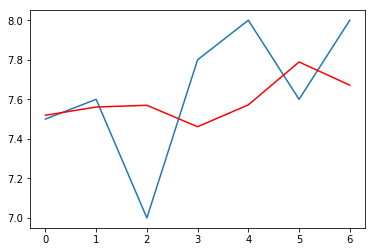

In [83]:
# Arima model, possible benchmark?
trainData = data1[0][:39].values
testData = data1[0][39:46].values

history = [x for x in trainData]
predictions = list()

for t in range(len(testData)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = testData[t]
    history.append(obs)
    
plt.plot(testData)
plt.plot(predictions, color='red')
plt.show()

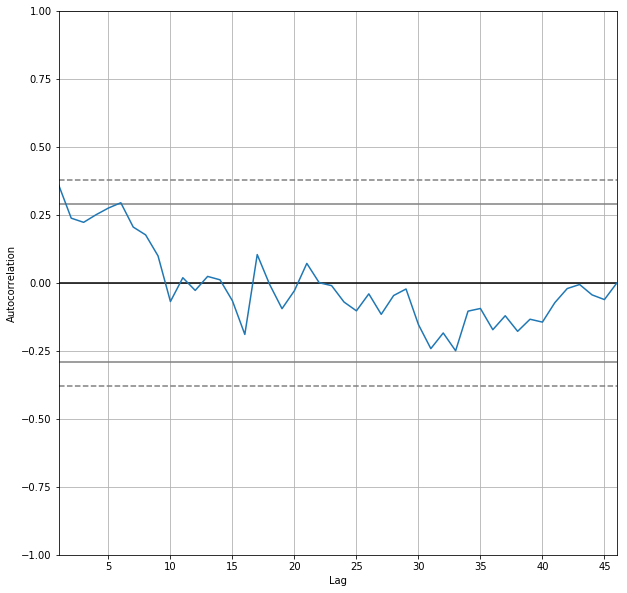

In [62]:
# Autocorrelation
moodp1 = data3[0][:46]
plt.figure(figsize=[10,10])
autocorrelation_plot(moodp1)